### Clustering Similar Players

In [92]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [93]:
data_02_24 = pd.read_csv('./data/cleaned/data_02_24.csv')
data_15_24 = pd.read_csv('./data/cleaned/data_15_24.csv')

fix cols

In [94]:
data_02_24 = data_02_24.drop(columns=['Unnamed: 0', 'Team'])
data_15_24 = data_15_24.drop(columns=['Unnamed: 0', 'Team'])
df = data_15_24.copy()
df = df.dropna(axis=1)
df = df[df['PA'] > 100]

#### Normalization
<small> all code standard across ipynb when normalization is required (I should probably refactor into .py lol)

In [95]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
        return avg

In [96]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    return np.sqrt(variance)

In [97]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

In [98]:
# df to store mean results
mean_values = pd.DataFrame(index=df['Season'].unique())

for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = df.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,...,Barrel%,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,2015,473.000807,28.406830,0.078561,0.196159,0.302323,101.703441,0.109003,3.326956,-0.555203,...,0.051987,110.141662,0.342330,0.306820,0.675174,0.656059,0.872782,0.795164,0.096545,0.263119
1,2016,481.366746,28.519147,0.083881,0.203510,0.302725,101.917382,0.051932,4.103679,-0.795624,...,0.060926,110.415648,0.353323,0.303360,0.671929,0.646008,0.867408,0.787936,0.099088,0.265533
2,2017,476.786961,28.345259,0.087652,0.208815,0.302744,101.937393,0.057559,3.652319,-0.729389,...,0.061091,110.222937,0.343395,0.298602,0.672624,0.635855,0.859684,0.781037,0.102645,0.268009
3,2018,471.915997,28.115974,0.086914,0.214215,0.298732,101.714562,0.148301,3.795978,-0.958030,...,0.066110,110.463651,0.362899,0.309133,0.679535,0.636317,0.860804,0.776377,0.105250,0.270896
4,2019,464.914972,27.950325,0.087278,0.220105,0.300689,102.210402,0.093780,4.359199,-0.832427,...,0.072297,110.588608,0.374544,0.316182,0.692080,0.633711,0.854930,0.769328,0.109512,0.270603


In [99]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=df['Season'].unique())

# Loop through numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = df.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,...,Barrel%,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,2015,165.937131,3.920175,0.030939,0.057592,0.037114,27.346927,3.263287,15.699682,8.380724,...,0.036316,3.140128,0.082114,0.056871,0.059338,0.089534,0.049212,0.059221,0.031697,0.027038
1,2016,171.285879,3.939726,0.030104,0.059157,0.036182,25.015749,2.717802,14.769137,9.410718,...,0.037048,3.369109,0.078093,0.055723,0.057835,0.088766,0.048051,0.058334,0.030790,0.026258
2,2017,160.880361,3.820437,0.032471,0.061165,0.036608,25.958521,2.727740,15.733877,8.659952,...,0.038383,3.490023,0.077479,0.058800,0.057204,0.087512,0.049874,0.060109,0.032000,0.028312
3,2018,163.940483,3.703694,0.031847,0.060666,0.037349,26.519238,2.519796,15.510276,8.723117,...,0.037651,3.395719,0.077966,0.061093,0.058005,0.085400,0.048408,0.058746,0.031973,0.028248
4,2019,164.230152,3.666218,0.031678,0.060823,0.037735,27.166508,2.406099,16.262761,8.849027,...,0.039366,3.355495,0.075813,0.061697,0.059757,0.088034,0.047627,0.058396,0.032008,0.028158


In [100]:
df_zscore = z_scores(df, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,Barrel%,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,aaron altherr,2015,81.197650,88.758588,106.728812,110.157560,99.663901,108.281754,102.880918,101.458941,...,91.247739,99.631664,111.205531,88.289787,92.748111,87.764672,100.594162,95.423451,99.705471,107.032104
1,aaron altherr,2016,85.149579,91.067534,105.793491,116.980938,95.930300,84.821145,98.809770,90.212836,...,91.924398,103.785427,99.425572,93.647390,94.428432,86.816714,92.509824,89.522559,105.924618,115.299310
2,aaron altherr,2017,95.972973,93.861281,96.925894,107.130264,106.898873,106.849736,95.644590,103.596516,...,109.265288,105.842550,111.336219,97.640806,93.793172,86.779711,94.135434,90.137003,106.569011,113.317089
3,aaron altherr,2018,88.598545,96.986862,112.372063,117.321778,86.035152,89.546542,101.887744,92.120333,...,108.311301,112.287087,111.754754,93.497407,100.897211,74.445289,94.224099,85.487124,110.407999,114.134229
5,aaron hicks,2015,94.998057,91.309495,102.785780,95.324366,95.386134,97.828088,100.982365,96.936795,...,93.333819,92.635135,98.904352,88.448499,102.169352,97.027102,100.881173,101.523409,96.911449,92.821100


#### Player Avg Data

clean player names

In [101]:
# borrowed from player att ipynb
def clean_names(df):
    df['Name'] = df['Name'].str.split(',').str[0]
    df['Name'] = df['Name'].str.replace(r'[^a-z\s]', '', regex=True)
    return df

carrer averages 

In [102]:
# clean names
df_player = clean_names(df_zscore)
df_player = df_player.drop(columns=['Season'])

# df to store mean results
df_zscore_mean = pd.DataFrame()

# Loop through each group (player names)
for name, group in df_player.groupby('Name'):
    weighted_means = {}
    for col in group.select_dtypes(include=[np.number]).columns:
        if col != 'PA':  
            weighted_means[col] = np.average(group[col], weights=group['PA'])
    weighted_means['Name'] = name  
    df_zscore_mean = pd.concat([df_zscore_mean, pd.DataFrame([weighted_means])], ignore_index=True)


cols = ['Name'] + [col for col in df_zscore_mean.columns if col != 'Name']
df_zscore_mean = df_zscore_mean[cols]

#### Clustering Methods

In [103]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

##### KMeans

In [104]:
X = df_zscore_mean.drop(columns=['Age', 'wRC+', 'Name']) # dont include age 

wcss = []
for i in range(2,20):
    kmeans_clust = KMeans(n_clusters=i, init='k-means++', random_state=42)
    labels = kmeans_clust.fit_predict(X)
    score = silhouette_score(X, labels)
    wcss.append(score)

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

##### Spectral 'rbf'

In [105]:
X1 = df_zscore_mean.drop(columns=['Age', 'wRC+', 'Name']) # dont include age 
gamma = [0.0001 ,0.001, 0.01]
n_clusters = [2, 3, 4, 5, 6]

# training matrix to min silo score
para_matrix = pd.DataFrame(columns=['silo', 'gamma', 'clusters'])
i = 0
g = 0
for gamma in gamma:
    g += 1
    for cluster in n_clusters:
        i += 1
        spectral = SpectralClustering(n_clusters=cluster, 
                                      gamma=gamma,
                                      affinity='rbf', 
                                      assign_labels='kmeans',
                                      n_init=20,
                                      random_state=26)
        labels = spectral.fit_predict(X)
        loss_kinda = np.nan
        if (len(set(labels))) > 1:
            loss_kinda = silhouette_score(X, labels)
        para_matrix.loc[len(para_matrix)] = [loss_kinda, gamma, cluster]
       

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

##### Spectral 'nearest neighbor'

In [106]:
n_clusters = [2, 3, 4, 5, 6]
n_neighbors = [6, 7, 8, 9, 10]

# training matrix to min silo score
para_matrix_nmeans = pd.DataFrame(columns=['silo', 'neighbors', 'clusters'])
g = 0
for neigh in n_neighbors:
    g += 1
    i = 0
    for cluster in n_clusters:
        i += 1
        spectral = SpectralClustering(n_clusters=cluster, 
                                      affinity='nearest_neighbors', 
                                      n_neighbors=neigh,
                                      assign_labels='kmeans',
                                      n_init=20,
                                      random_state=26)
        labels = spectral.fit_predict(X)
        loss_kinda = np.nan
        if (len(set(labels))) > 1:
            loss_kinda = silhouette_score(X, labels)
        para_matrix_nmeans.loc[len(para_matrix_nmeans)] = [loss_kinda, neigh, cluster]
        

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

#### Applying Player Clusters to Dataframes

Player Clusters

In [107]:
model = SpectralClustering(n_clusters=2, 
                                      gamma=0.01,
                                      affinity='nearest_neighbors', 
                                      n_neighbors=8,
                                      assign_labels='kmeans',
                                      n_init=100,
                                      random_state=40)
labels = model.fit_predict(X)

c:\Users\dalto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


add to individual player df 

In [108]:
df_zscore_mean['Cluster'] = labels
df_zscore_mean.head()

,Name,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,...,maxEV,HardHit%,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,Cluster
0,aaron altherr,92.791828,105.245638,112.794092,97.295717,97.467260,99.663244,96.956934,101.297227,94.821392,...,105.533373,108.521560,93.462011,95.499103,83.902451,95.257828,90.037137,105.793776,112.550121,1
1,aaron hicks,102.164326,113.783688,99.037496,93.152391,99.980621,103.071443,99.743476,98.889636,97.801609,...,95.289220,98.083109,86.997798,95.001708,96.877947,94.138133,96.931995,97.997937,100.745961,0
2,aaron hill,112.838404,103.447632,90.633893,90.889066,91.806992,98.917058,91.760734,100.690602,92.206867,...,84.144215,91.376148,88.863549,92.993404,103.464120,109.415412,109.441030,89.644043,98.443807,0
3,aaron judge,101.137386,123.038342,109.515987,111.918299,125.328693,97.862532,129.468036,99.749432,125.088607,...,123.354648,124.620345,88.792494,98.446441,81.444102,90.747886,86.216784,106.481564,107.743224,1
4,abraham almonte,100.302168,102.940700,102.082150,94.979356,91.574948,100.817883,95.027786,98.778702,90.809798,...,99.201381,102.065916,98.730960,101.297546,95.983305,99.113244,97.109252,101.980913,99.062572,1


count in each cluster

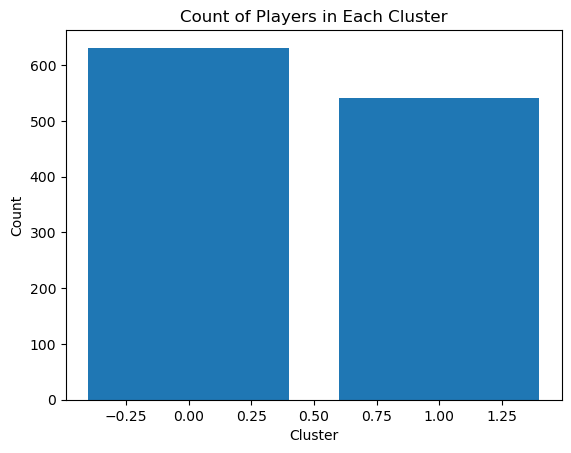

In [109]:
# Count the number of players in each cluster
cluster_counts = df_zscore_mean['Cluster'].value_counts()

# Plot the counts as a bar chart
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of Players in Each Cluster')
plt.show()

mapping clusters to players
<br>
<small> add the clusters back to player name

In [110]:
# Create a dictionary mapping player names to their clusters
name_to_cluster = df_zscore_mean.set_index('Name')['Cluster'].to_dict()

# Map the clusters to the df_zscore DataFrame
df_zscore['Cluster'] = df_zscore['Name'].map(name_to_cluster)

add numeric age to df
<br>
<small> for groupby functions its better to not have it normalized

In [111]:
df_zscore_age = df_zscore.copy()
df_zscore_age['Age'] = df['Age']

#### Averages and Analysis

Mean for Each Cluster by Age
<br>
<small> weighted avg based on PA for each stat by age 

In [112]:
cluster_means = pd.DataFrame()
for col in df_zscore_age.select_dtypes(include=np.number).columns:
    cluster_means[col] = df_zscore_age.groupby(['Cluster', 'Age']).apply(lambda group: np.average(group[col], weights=group['PA']))
cluster_means = cluster_means.reset_index(drop=True)
cluster_means['Age'] = round(cluster_means['Age'])
cluster_means = cluster_means.drop(columns=['Season'])


C:\Users\dalto\AppData\Local\Temp\ipykernel_17040\4055931871.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_means[col] = df_zscore_age.groupby(['Cluster', 'Age']).apply(lambda group: np.average(group[col], weights=group['PA']))
C:\Users\dalto\AppData\Local\Temp\ipykernel_17040\4055931871.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_means[col] = df_zscore_age.groupby(['Cluster', '

individual precent change
<br>
<small > looking at the precent change for each player comapared to there own previous season

In [113]:
change_df = df_zscore_age.copy()
for col in change_df.select_dtypes(include=np.number).columns:
    if col not in ['PA', 'Season', 'Age', 'Cluster']:
        change_df[f'{col} % change'] = df_zscore_age.groupby('Name')[col].pct_change() * 100
        change_df = change_df.drop(columns=col)
change_df = change_df.dropna()

mean % change over year average

In [114]:
average_precent_change = pd.DataFrame()
for col in change_df.select_dtypes(include=np.number).columns:
    if col not in ['Cluster']:
        average_precent_change[f'{col}'] = [np.average(change_df[col], weights=change_df['PA'])]
average_precent_change.head()

,Season,PA,Age,BB% % change,K% % change,BABIP % change,wRC+ % change,BsR % change,Off % change,Def % change,...,Barrel% % change,maxEV % change,HardHit% % change,O-Swing% % change,Z-Swing% % change,O-Contact% % change,Z-Contact% % change,Contact% % change,SwStr% % change,CSW% % change
0,2020.065101,98.047114,28.808742,0.247214,0.037651,-0.353471,-0.377363,-0.116289,-0.220554,-0.184686,...,-0.171614,-0.109819,-0.273177,0.266419,0.219709,0.284714,0.39871,0.271277,0.096853,0.168253


mean % change year over year by cluster

In [115]:
cluster_precent_change = pd.DataFrame()
for col in change_df.select_dtypes(include=np.number).columns:
    if col not in ['Cluster']:
        cluster_precent_change[f'{col}'] = change_df.groupby('Cluster').apply(lambda group: np.average(group[col], weights=group['PA']))
cluster_precent_change.head()

C:\Users\dalto\AppData\Local\Temp\ipykernel_17040\3191096024.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_precent_change[f'{col}'] = change_df.groupby('Cluster').apply(lambda group: np.average(group[col], weights=group['PA']))
C:\Users\dalto\AppData\Local\Temp\ipykernel_17040\3191096024.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_precent_change[f'{col}'] = change_df.groupby('C

,Season,PA,Age,BB% % change,K% % change,BABIP % change,wRC+ % change,BsR % change,Off % change,Def % change,...,Barrel% % change,maxEV % change,HardHit% % change,O-Swing% % change,Z-Swing% % change,O-Contact% % change,Z-Contact% % change,Contact% % change,SwStr% % change,CSW% % change
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2020.028385,98.032746,29.027700,0.123991,0.017693,-0.316738,-0.266504,-0.052324,-0.183204,-0.198598,...,-0.212446,0.051147,-0.329385,0.332344,0.276996,0.266756,0.292161,0.218134,0.117447,0.146097
1,2020.111511,98.065276,28.531979,0.402967,0.062879,-0.399902,-0.517488,-0.197140,-0.267765,-0.167101,...,-0.120003,-0.313279,-0.202131,0.183090,0.147298,0.307413,0.533387,0.338449,0.070822,0.196257


overall age % change year over year

In [116]:
age_percent = pd.DataFrame()
for col in change_df.select_dtypes(include=np.number).columns:
    if col not in ['Cluster', 'Age']:
        age_percent[f'{col}'] = change_df.groupby('Age')[col].mean()
age_percent.head()


,Season,PA,BB% % change,K% % change,BABIP % change,wRC+ % change,BsR % change,Off % change,Def % change,WAR % change,Barrel% % change,maxEV % change,HardHit% % change,O-Swing% % change,Z-Swing% % change,O-Contact% % change,Z-Contact% % change,Contact% % change,SwStr% % change,CSW% % change
Age,,,,,,,,,,,,,,,,,,,,
20.0,2019.000000,111.817868,1.024560,-1.002074,-6.890509,-1.447477,-1.896868,3.822983,7.713305,8.479539,0.912112,-2.566585,5.823683,1.668208,13.220435,-6.378500,3.148868,-2.323267,2.875021,-7.836632
21.0,2019.333333,105.195789,0.997078,-2.711111,-5.514797,-1.461460,5.066690,1.301731,3.534531,4.895898,1.706168,3.198660,3.005271,-0.261810,1.797027,3.805847,0.988859,3.110531,-1.822618,-4.236035
22.0,2020.534884,101.845782,-0.164053,-1.293945,0.937521,3.596151,3.516515,4.430206,1.805228,6.955419,3.097655,3.384973,1.310922,2.239740,2.247510,0.604630,2.055594,1.108301,0.340874,-2.123104
23.0,2019.821429,100.506735,0.461375,-1.643077,-0.212215,0.169172,0.261660,-0.231860,1.151522,1.465329,-0.527567,1.570135,2.469909,-0.393878,0.674502,1.827978,2.691333,2.387101,-1.628217,-2.385462
24.0,2020.023256,97.968110,0.172620,-0.929780,-0.268253,0.571207,0.020490,0.689098,-0.268448,1.326087,0.185405,0.886519,-0.199322,0.274186,0.453749,1.296807,1.051255,1.169842,-0.510143,-0.931977


cluster and age mean % change
<br>
<small> no diffrent from above except further seperating by age

In [117]:
cluster_age_precent_change = pd.DataFrame()
for col in change_df.select_dtypes(include=np.number).columns:
    if col not in ['Cluster', 'Age']:
        cluster_age_precent_change[f'{col}'] = change_df.groupby(['Age', 'Cluster'])[col].mean()
cluster_age_precent_change = cluster_age_precent_change.reset_index()
cluster_age_precent_change = cluster_age_precent_change.drop(columns = ['Season'])
cluster_age_precent_change.head()

,Age,Cluster,PA,BB% % change,K% % change,BABIP % change,wRC+ % change,BsR % change,Off % change,Def % change,...,Barrel% % change,maxEV % change,HardHit% % change,O-Swing% % change,Z-Swing% % change,O-Contact% % change,Z-Contact% % change,Contact% % change,SwStr% % change,CSW% % change
0,20.0,1,111.817868,1.024560,-1.002074,-6.890509,-1.447477,-1.896868,3.822983,7.713305,...,0.912112,-2.566585,5.823683,1.668208,13.220435,-6.378500,3.148868,-2.323267,2.875021,-7.836632
1,21.0,0,101.108428,-0.690238,-0.643755,-3.948976,-2.637992,5.721887,0.175809,2.887118,...,-0.699035,4.219755,0.294885,2.322320,3.389988,-0.755352,3.815698,1.538927,-0.310947,-3.313552
2,21.0,1,108.465678,2.346930,-4.364996,-6.767454,-0.520234,4.542533,2.202468,4.052461,...,3.630330,2.381784,5.173580,-2.329114,0.522659,7.454806,-1.272613,4.367814,-3.031956,-4.974020
3,22.0,0,103.564503,-1.396065,-0.950845,1.384133,1.891222,4.003986,3.170849,0.319280,...,3.190703,6.981596,2.017316,4.190270,0.937481,1.199162,4.972773,2.353264,-0.753141,-1.558670
4,22.0,1,100.485127,0.811290,-1.565566,0.583954,4.945885,3.130601,5.427197,2.981604,...,3.023992,0.537647,0.751694,0.695570,3.284616,0.133959,-0.253840,0.122704,1.206969,-2.569947


seperating age precent change by cluster to graph

In [118]:
cluster_age_precent_change_one = cluster_age_precent_change.query('Cluster == 1')
cluster_age_precent_change_zero = cluster_age_precent_change.query('Cluster == 0')

#### Exploring this graphically

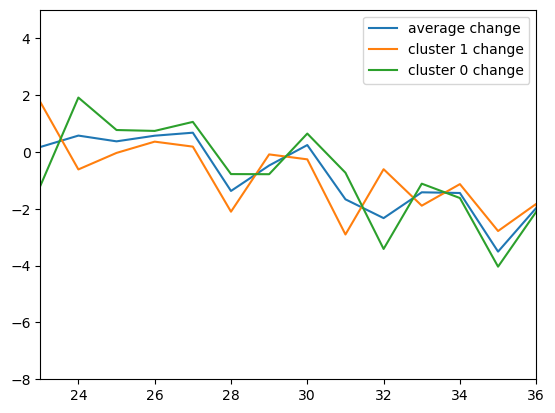

In [119]:
plt.plot(age_percent.index, age_percent["wRC+ % change"], label = 'average change')
plt.plot(cluster_age_precent_change_one['Age'],cluster_age_precent_change_one['wRC+ % change'], label = 'cluster 1 change')
plt.plot(cluster_age_precent_change_zero['Age'],cluster_age_precent_change_zero['wRC+ % change'], label = 'cluster 0 change')
plt.xlim(23, 36)
plt.ylim(-8, 5)
plt.legend()

Export Age Precent

In [125]:
age_wrc_export = age_percent.reset_index()
age_wrc_export = age_wrc_export[['Age', 'wRC+ % change']]
age_wrc_export = age_wrc_export.reset_index()

# rolling averages
age_wrc_export['wRC+ % change'] = age_wrc_export['wRC+ % change'].rolling(window=3, center=True, min_periods=1).apply(
    lambda x: 0.25 * x.iloc[0] + 0.5 * x.iloc[1] + 0.25 * x.iloc[2] if len(x) == 3 
    else x.iloc[0]
)

# index
age_wrc_export = age_wrc_export.drop(columns=['index'])
age_wrc_export.to_csv('./models/2025_Predections/age_curves.csv')